In [25]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from Codes.custom_datagen import imageLoader,load_img
import random

2.8.0
2.8.0


In [26]:
import segmentation_models_3D as sm

In [28]:
train_img_dir = "D:/1803070/Brats/Splited_Combined/train/images/"
train_mask_dir = "D:/1803070/Brats/Splited_Combined/train/masks/"

val_img_dir = "D:/1803070/Brats/Splited_Combined/val/images/"
val_mask_dir = "D:/1803070/Brats/Splited_Combined/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [29]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(121)
# plt.imshow(test_img[:,:,n_slice], cmap='gray')
# plt.title('Image t2')
# plt.subplot(122)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()

In [30]:
test_img.shape

(140, 170, 155, 4)

In [31]:
import segmentation_models_3D as sm
from tensorflow.keras.optimizers import Adam


# wt0, wt1, wt2, wt3 = 0.25, 53.35, 53.35, 36.45
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = Adam(LR)

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [32]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' 


def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (3, 3, 3), strides=(2, 2, 2), padding='valid')(c5)
    print(u6.shape, c4.shape, c5.shape)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (3, 2, 2), strides=(2, 2, 2), padding='valid')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 3, 3), strides=(2, 2, 2), padding='valid')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 3), strides=(2, 2, 2), padding='valid')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

In [33]:
def dice_coef(y_true, y_pred):
    smooth = 1e-15
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)  

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-15) / (union + 1e-15)
# def dice_coef_loss(y_true, y_pred):
#     return -dice_coef(y_true, y_pred)

In [34]:
def conv_block_3d(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def res_conv_block_3d(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv3D(size, (filter_size, filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization()(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv3D(size, kernel_size=(1, 1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization()(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)
    return res_path


In [35]:
def channel_attention_3d(input_tensor):
    channel_avg = layers.GlobalAveragePooling3D()(input_tensor)
    
    dense_1 = layers.Dense(units=input_tensor.shape[-1] // 2, activation='relu')(channel_avg)
    dense_2 = layers.Dense(units=input_tensor.shape[-1], activation='sigmoid')(dense_1)
    
    reshaped = layers.Reshape((1, 1, 1, input_tensor.shape[-1]))(dense_2)
    
    multiplied = layers.Multiply()([input_tensor, reshaped])
    return multiplied



def spatial_attention_3d(input_feature):
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_feature)
    concatenated = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    conv1 = layers.Conv3D(filters=1, kernel_size=(7, 7, 7), padding='same', activation='sigmoid')(concatenated)
    multiplied = layers.Multiply()([input_feature, conv1])
    
    return multiplied


def cbam_3d(input_tensor):
    channel_attention_output = channel_attention_3d(input_tensor)
    cbam_output = spatial_attention_3d(channel_attention_output)
    return cbam_output

# def cbam_3d(input_tensor):
#     channel_attention_output = channel_attention_3d(input_tensor)
#     spatial_attention_output = spatial_attention_3d(input_tensor)
    
#     combined_attention = layers.Add()([channel_attention_output, spatial_attention_output])
#     return combined_attention

In [36]:
def Attention_ResUNet_3D_sp(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True):

    FILTER_NUM = 16
    FILTER_SIZE = 3 
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 4  # (batch_size, x, y, z, channels)

    # Downsampling layers
    conv_128 = res_conv_block_3d(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_128)
    
    conv_64 = res_conv_block_3d(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_64)
    
    conv_32 = res_conv_block_3d(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_32)
    
    conv_16 = res_conv_block_3d(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_16)
    
    conv_8 = res_conv_block_3d(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    att_16 = spatial_attention_3d(conv_16)
    up_16 = layers.Conv3DTranspose(8*FILTER_NUM, (3, 3, 3), strides=(2, 2, 2), padding='valid')(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block_3d(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    
    att_32 = spatial_attention_3d(conv_32)
    up_32 = layers.Conv3DTranspose(4*FILTER_NUM, (3, 2, 2), strides=(2, 2, 2), padding='valid')(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block_3d(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    
    att_64 = spatial_attention_3d(conv_64)
    up_64 = layers.Conv3DTranspose(2*FILTER_NUM, (2, 3, 3), strides=(2, 2, 2), padding='valid')(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block_3d(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    
    att_128 = spatial_attention_3d(conv_128)
    up_128 = layers.Conv3DTranspose(FILTER_NUM, (2, 2, 3), strides=(2, 2, 2), padding='valid')(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block_3d(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    
    up_conv_128 = channel_attention_3d(up_conv_128)

    
    
    conv_final = layers.Conv3D(NUM_CLASSES, kernel_size=(1,1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet_3D")
    return model


In [21]:
# from  Codes.simple_3d_unet import simple_unet_model

# model = simple_unet_model(IMG_HEIGHT=test_img.shape[0], 
#                           IMG_WIDTH=test_img.shape[1], 
#                           IMG_DEPTH=test_img.shape[2], 
#                           IMG_CHANNELS=1, 
#                           num_classes=4)

# model.compile(optimizer = optim, loss=sm.losses.cce_dice_loss , metrics=metrics)
# print(model.summary())

# print(model.input_shape)
# print(model.output_shape)

In [32]:
def Attention_ResUNet_3D_ch(input_shape, NUM_CLASSES=4, dropout_rate=0.0, batch_norm=True):

    FILTER_NUM = 16
    FILTER_SIZE = 3 
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 4  # (batch_size, x, y, z, channels)

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block_3d(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block_3d(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block_3d(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block_3d(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block_3d(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    att_16 = channel_attention_3d(conv_16)
    up_16 = layers.Conv3DTranspose(8*FILTER_NUM, (3, 3, 3), strides=(2, 2, 2), padding='valid')(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block_3d(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    att_32 = channel_attention_3d(conv_32)
    up_32 = layers.Conv3DTranspose(4*FILTER_NUM, (3, 2, 2), strides=(2, 2, 2), padding='valid')(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block_3d(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    att_64 = channel_attention_3d(conv_64)
    up_64 = layers.Conv3DTranspose(2*FILTER_NUM, (2, 3, 3), strides=(2, 2, 2), padding='valid')(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block_3d(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    att_128 = channel_attention_3d(conv_128)
    up_128 = layers.Conv3DTranspose(FILTER_NUM, (2, 2, 3), strides=(2, 2, 2), padding='valid')(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block_3d(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    
    up_conv_128 = channel_attention_3d(up_conv_128)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv3D(NUM_CLASSES, kernel_size=(1,1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet_3D_ch")
    return model


In [37]:
from tensorflow.keras.optimizers import Adam
from keras import backend, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger


checkpoint_callback = ModelCheckpoint('model_sp_val.h5', save_best_only=True, save_weights_only=True, monitor='val_iou', mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir='logs_sp_val', histogram_freq=0, write_graph=True, write_images=False)
# reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5, verbose=1)
csv_logger_callback = CSVLogger('training_sp_val.log')

cb =  [checkpoint_callback, tensorboard_callback, csv_logger_callback]

metrics = [dice_coef, iou]

In [38]:
model = Attention_ResUNet_3D_sp(input_shape = (140, 170, 155, 4))
model.compile(optimizer=Adam(lr = 0.001), loss=dice_coef_loss, 
              metrics=metrics)

model.summary()

Model: "AttentionResUNet_3D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 140, 170, 1  0           []                               
                                55, 4)]                                                           
                                                                                                  
 conv3d_64 (Conv3D)             (None, 140, 170, 15  1744        ['input_3[0][0]']                
                                5, 16)                                                            
                                                                                                  
 batch_normalization_56 (BatchN  (None, 140, 170, 15  64         ['conv3d_64[0][0]']              
 ormalization)                  5, 16)                                          

                                                                                                  
 batch_normalization_63 (BatchN  (None, 35, 42, 38,   256        ['conv3d_71[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 add_20 (Add)                   (None, 35, 42, 38,   0           ['batch_normalization_64[0][0]', 
                                64)                               'batch_normalization_63[0][0]'] 
                                                                                                  
 activation_43 (Activation)     (None, 35, 42, 38,   0           ['add_20[0][0]']                 
                                64)                                                               
                                                                                                  
 max_pooli

 spose)                         128)                                                              
                                                                                                  
 multiply_10 (Multiply)         (None, 17, 21, 19,   0           ['activation_45[0][0]',          
                                128)                              'conv3d_79[0][0]']              
                                                                                                  
 concatenate_17 (Concatenate)   (None, 17, 21, 19,   0           ['conv3d_transpose_8[0][0]',     
                                256)                              'multiply_10[0][0]']            
                                                                                                  
 conv3d_80 (Conv3D)             (None, 17, 21, 19,   884864      ['concatenate_17[0][0]']         
                                128)                                                              
          

 add_24 (Add)                   (None, 35, 42, 38,   0           ['batch_normalization_76[0][0]', 
                                64)                               'batch_normalization_75[0][0]'] 
                                                                                                  
 concatenate_20 (Concatenate)   (None, 70, 85, 77,   0           ['lambda_20[0][0]',              
                                2)                                'lambda_21[0][0]']              
                                                                                                  
 activation_51 (Activation)     (None, 35, 42, 38,   0           ['add_24[0][0]']                 
                                64)                                                               
                                                                                                  
 conv3d_87 (Conv3D)             (None, 70, 85, 77,   687         ['concatenate_20[0][0]']         
          

                                                                                                  
 batch_normalization_82 (BatchN  (None, 140, 170, 15  64         ['conv3d_94[0][0]']              
 ormalization)                  5, 16)                                                            
                                                                                                  
 batch_normalization_81 (BatchN  (None, 140, 170, 15  64         ['conv3d_93[0][0]']              
 ormalization)                  5, 16)                                                            
                                                                                                  
 add_26 (Add)                   (None, 140, 170, 15  0           ['batch_normalization_82[0][0]', 
                                5, 16)                            'batch_normalization_81[0][0]'] 
                                                                                                  
 activatio

In [39]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    shuffle=True,
                    callbacks = cb)

Epoch 1/50
360/360 [==============================] - ETA: 0s - loss: 0.5734 - dice_coef: 0.4266 - iou: 0.2717
Epoch 1: val_iou improved from -inf to 0.31877, saving model to model_sp_val.h5
360/360 [==============================] - 1018s 3s/step - loss: 0.5734 - dice_coef: 0.4266 - iou: 0.2717 - val_loss: 0.5167 - val_dice_coef: 0.4833 - val_iou: 0.3188
Epoch 2/50
360/360 [==============================] - ETA: 0s - loss: 0.4684 - dice_coef: 0.5316 - iou: 0.3625
Epoch 2: val_iou improved from 0.31877 to 0.40966, saving model to model_sp_val.h5
360/360 [==============================] - 971s 3s/step - loss: 0.4684 - dice_coef: 0.5316 - iou: 0.3625 - val_loss: 0.4189 - val_dice_coef: 0.5811 - val_iou: 0.4097
Epoch 3/50
360/360 [==============================] - ETA: 0s - loss: 0.3735 - dice_coef: 0.6264 - iou: 0.4565
Epoch 3: val_iou improved from 0.40966 to 0.51732, saving model to model_sp_val.h5
360/360 [==============================] - 977s 3s/step - loss: 0.3735 - dice_coef: 0.62

Epoch 24/50
360/360 [==============================] - ETA: 0s - loss: 0.0131 - dice_coef: 0.9869 - iou: 0.9742
Epoch 24: val_iou improved from 0.96739 to 0.96982, saving model to model_sp_val.h5
360/360 [==============================] - 975s 3s/step - loss: 0.0131 - dice_coef: 0.9869 - iou: 0.9742 - val_loss: 0.0154 - val_dice_coef: 0.9846 - val_iou: 0.9698
Epoch 25/50
360/360 [==============================] - ETA: 0s - loss: 0.0121 - dice_coef: 0.9879 - iou: 0.9761
Epoch 25: val_iou improved from 0.96982 to 0.97036, saving model to model_sp_val.h5
360/360 [==============================] - 976s 3s/step - loss: 0.0121 - dice_coef: 0.9879 - iou: 0.9761 - val_loss: 0.0151 - val_dice_coef: 0.9849 - val_iou: 0.9704
Epoch 26/50
360/360 [==============================] - ETA: 0s - loss: 0.0113 - dice_coef: 0.9887 - iou: 0.9777
Epoch 26: val_iou did not improve from 0.97036
360/360 [==============================] - 1001s 3s/step - loss: 0.0113 - dice_coef: 0.9887 - iou: 0.9777 - val_loss:

In [40]:
model.save('brats_3d_full_sp.hdf5')

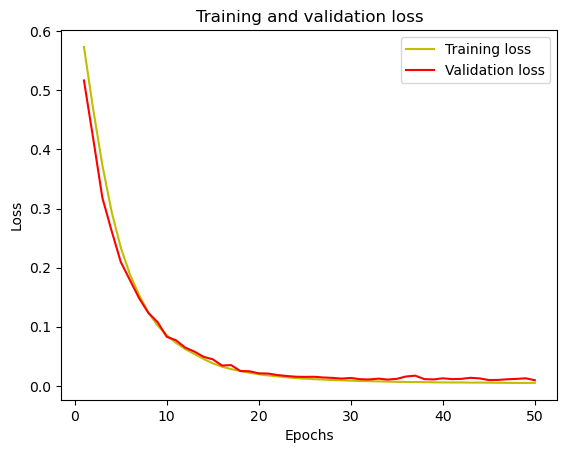

In [41]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

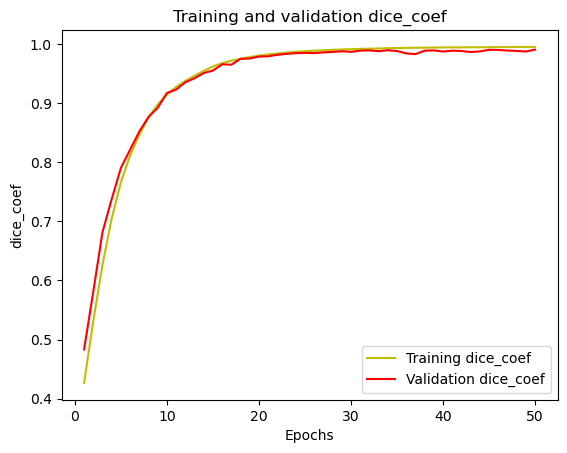

In [42]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training dice_coef')
plt.plot(epochs, val_acc, 'r', label='Validation dice_coef')
plt.title('Training and validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dice_coef')
plt.legend()
plt.show()

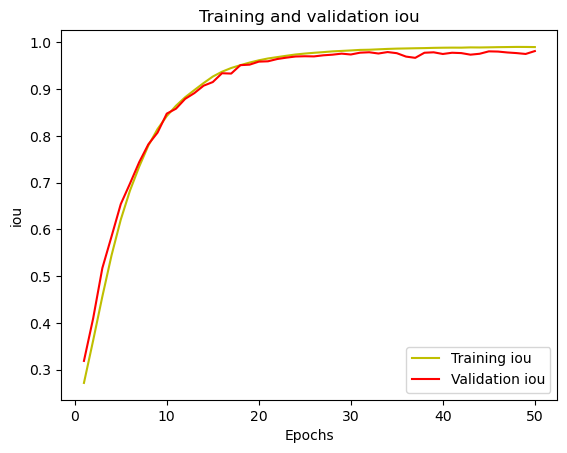

In [43]:
acc = history.history['iou']
val_acc = history.history['val_iou']
plt.plot(epochs, acc, 'y', label='Training iou')
plt.plot(epochs, val_acc, 'r', label='Validation iou')
plt.title('Training and validation iou')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()